# 0.0. Imports

In [58]:
import pandas as pd
import numpy as np
import pymc3 as pm

from  matplotlib import pyplot as plt

## 0.1. Loading Data

In [2]:
df_raw = pd.read_csv( 'brazilian-ecommerce/olist_orders_dataset.csv' )

# 1.0. Data Description

In [3]:
df1 = df_raw.copy()

## 1.1. Data Dimensions

In [4]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 99441
Number of Cols: 8


## 1.2. Data Type

In [5]:
df1['order_purchase_timestamp'] = pd.to_datetime( df1['order_purchase_timestamp'] )
df1.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                        object
order_delivered_carrier_date             object
order_delivered_customer_date            object
order_estimated_delivery_date            object
dtype: object

## 1.3. Data Missing

In [6]:
df1.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

# 2.0. Feature Engineering

In [7]:
df2 = df1.copy()

## 2.0. Feature Creation

In [8]:
df2['order_purchase_year_week'] = df2['order_purchase_timestamp'].dt.strftime( '%Y-%W' )

# 3.0. Data Selection

In [9]:
df3 = df2.copy()

In [10]:
df3.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_purchase_year_week'],
      dtype='object')

In [11]:
df3 = df3[df3['order_status'] == 'canceled'][['order_id', 'order_purchase_year_week']]

In [12]:
df3.head()

,order_id,order_purchase_year_week
397,1b9ecfe83cdc259250e1a8aca174f0ad,2018-31
613,714fb133a6730ab81fa1d3c1b2007291,2018-04
1058,3a129877493c8189c59c60eb71d97c29,2018-04
1130,00b1cb0320190ca0daa2c88b35206009,2018-35
1801,ed3efbd3a87bea76c2812c66a0b32219,2018-38


# 4.0. Data Preparation

In [13]:
df4 = df3.copy()

In [14]:
df4 = df4.groupby( 'order_purchase_year_week' ).count().reset_index()
df4 = df4.sort_values( 'order_purchase_year_week' )

In [15]:
count_data = np.array( df4['order_id'] )
n_count_data = len( count_data )

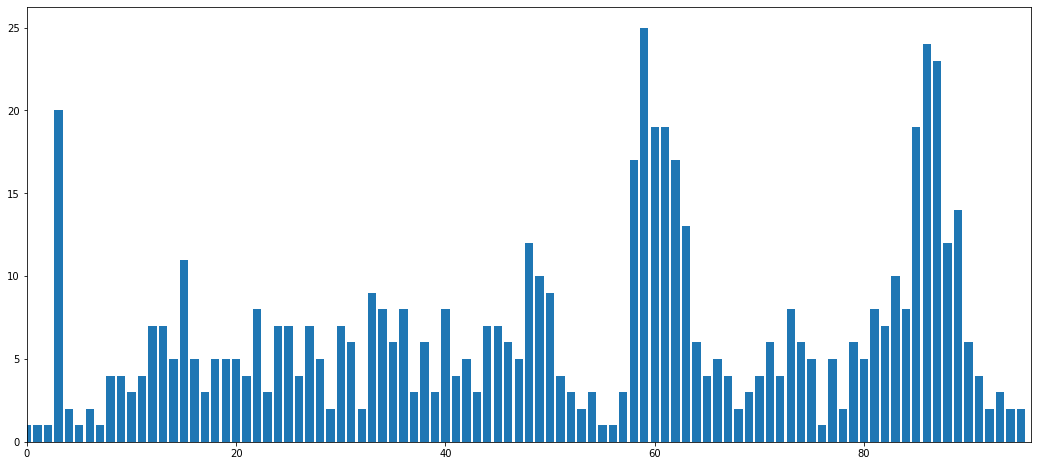

In [16]:
plt.figure( figsize=(18,8) )
plt.bar( np.arange( n_count_data ), count_data )
plt.xlim( [0, n_count_data ] );

# 5.0. Bayesian Inference

In [62]:
with pm.Model() as model:
    # Prior
    alpha = 1.0 / count_data.mean()
    lambda_01 = pm.Exponential( 'lambda_01', alpha )
    lambda_02 = pm.Exponential( 'lambda_02', alpha ) 

    tau = pm.DiscreteUniform( 'tau', lower=0, upper=n_count_data-1 )


    # Posterior
    idx = np.arange( n_count_data )
    lambda_ = pm.math.switch( tau >  idx, lambda_01, lambda_02 )
    obs = pm.Poisson( 'obs', lambda_, observed=count_data )

    # Likelihood
    trace = pm.sample( draws=10000, tune=5000, step=pm.Metropolis() )

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_02]
>Metropolis: [lambda_01]
Sampling 2 chains, 0 divergences: 100%|██████████| 30000/30000 [00:41<00:00, 731.13draws/s]
The number of effective samples is smaller than 25% for some parameters.


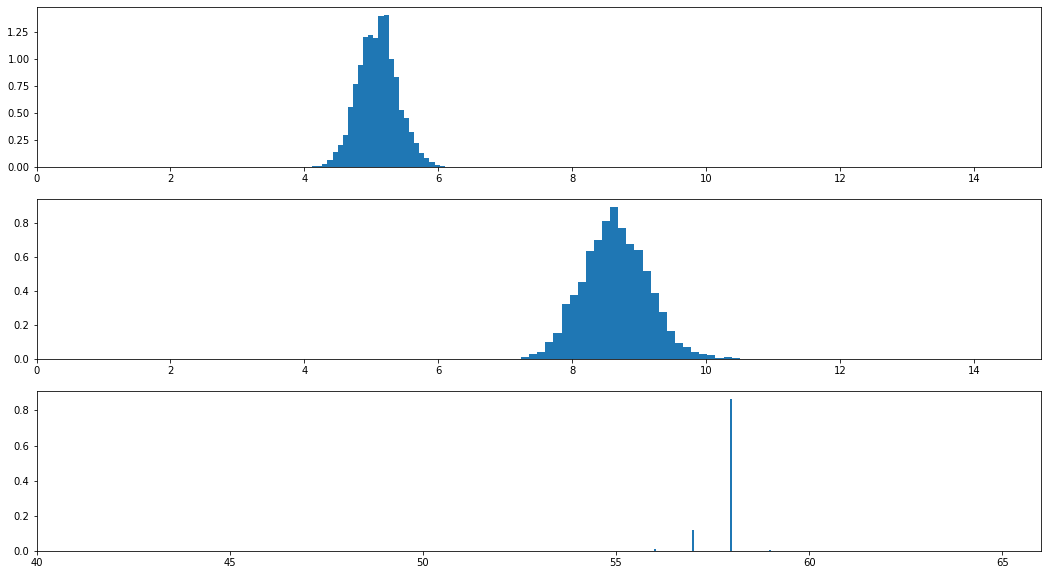

In [73]:
# posterior
plt.figure( figsize=(18, 10) )

plt.subplot( 311 )
plt.hist( trace['lambda_01'], histtype='stepfilled', bins=30, density=True );
plt.xlim( [0, 15 ] );

plt.subplot( 312 )
plt.hist( trace['lambda_02'], histtype='stepfilled', bins=30, density=True );
plt.xlim( [0, 15 ] );

plt.subplot( 313 )
w = 1.0 / trace['tau'].shape[0] * np.ones_like( trace['tau'] )
plt.hist( trace['tau'], bins=n_count_data, weights=w, rwidth=2. );
plt.xlim( [40, n_count_data-30 ] );

In [65]:
trace['lambda_01'].mean()

5.096977740102558

In [67]:
trace['lambda_02'].mean()

8.639950531948585

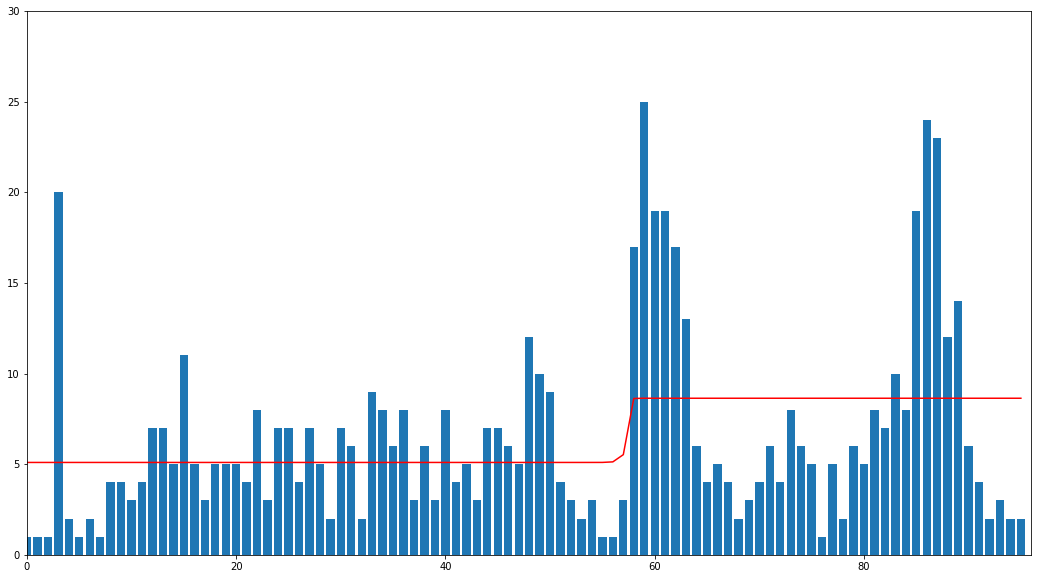

In [77]:
plt.figure( figsize=(18,10) )
# Behaviour plot
canceled_by_day = np.zeros( n_count_data )
for day in range( 0, n_count_data ):
    ix = day < trace['tau']
    canceled_by_day[day] = ( trace['lambda_01'][ix].sum() + trace['lambda_02'][~ix].sum() ) / trace['tau'].shape[0]
    
# plots 
plt.plot( range( n_count_data ), canceled_by_day, color='red' )
plt.ylim( [0, 30] )

plt.bar( np.arange( n_count_data ), count_data )
plt.xlim( [0, n_count_data ] );